In [1]:
%matplotlib inline

In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import imageio

In [3]:
plt.rcParams.update({
    "animation.writer": "ffmpeg",
    "font.family": "serif",  # use serif/main font for text elements
    "font.size": 12,
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "hist.bins": 20, # default number of bins in histograms
    "pgf.preamble": [
         "\\usepackage{units}",          # load additional packages
         "\\usepackage{metalogo}",
         "\\usepackage{unicode-math}",   # unicode math setup
         r"\setmathfont{xits-math.otf}",
         r"\setmainfont{DejaVu Serif}",  # serif font via preamble
         r'\usepackage{color}',
    ]
})

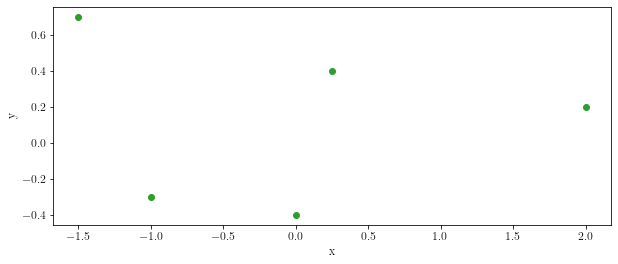

In [4]:
##Data
## orthogonal toy example
#x = torch.Tensor(np.array([-0.5,2]).reshape(-1,1)) 
#y = torch.Tensor(np.array([-1,1]).reshape(-1,1)) 
## non-orthognal toy exampe
x = torch.Tensor(np.array([-1.5,-1,0,0.25,2]).reshape(-1,1)) 
y = torch.Tensor(np.array([0.7,-0.3,-0.4,0.4,0.2]).reshape(-1,1)) 

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

# view data
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "tab:green")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Neural network architecture and initialisation

In [7]:
class Net(torch.nn.Module):
    """
    1 hidden layer Relu network
    """
    def __init__(self, n_feature, n_hidden, n_output, init_scale=1, bias_hidden=True, bias_output=False, balanced=True, **kwargs):
        """
        n_feature: dimension of input
        n_hidden: number of hidden neurons
        n_output: dimension of output
        init_scale: all the weights are initialized ~ N(0, init_scale^2/m) where m is the input dimension of this layer
        bias_hidden: if True, use bias parameters in hidden layer. Use no bias otherwise
        bias_output: if True, use bias parameters in output layer. Use no bias otherwise
        balanced: if True, use a balanced initialisation
        """
        super(Net, self).__init__()
        self.init_scale = init_scale
        
        self.hidden = torch.nn.Linear(n_feature, n_hidden, bias=bias_hidden)   # hidden layer with rescaled init
        torch.nn.init.normal_(self.hidden.weight.data, std=(init_scale/(n_hidden)))
        if bias_hidden:
            torch.nn.init.normal_(self.hidden.bias.data, std=(init_scale/(n_hidden*n_feature)))
            
        self.predict = torch.nn.Linear(n_hidden, n_output, bias=bias_output)   # output layer with rescaled init
        if balanced: # balanced initialisation
            if bias_hidden:
                neuron_norms = (self.hidden.weight.data.norm(dim=1).square()+self.hidden.bias.data.square()).sqrt()
            else:
                neuron_norms = (self.hidden.weight.data.norm(dim=1).square()).sqrt()
            self.predict.weight.data = 2*torch.bernoulli(0.5*torch.ones_like(self.predict.weight.data)) -1
            self.predict.weight.data *= neuron_norms
        else:
            torch.nn.init.normal_(self.predict.weight.data, std=(init_scale/n_hidden))
        if bias_output:
            torch.nn.init_normal_(self.predict.bias.data, std=(init_scale/n_hidden))
            
        self.activation = kwargs.get('activation', torch.nn.ReLU()) # activation of hidden layer

    def forward(self, z):
        z = self.activation(self.hidden(z))     
        z = self.predict(z)             # linear output
        return z

## Visualisation functions

In [8]:
def multicolor_label(ax,list_of_strings,list_of_colors,axis='x',anchorpad=0,**kw):
    """this function creates axes labels with multiple colors
    ax: specifies the axes object where the labels should be drawn
    list_of_strings: a list of all of the text items
    list_if_colors: a corresponding list of colors for the strings
    axis:'x', 'y', or 'both' and specifies which label(s) should be drawn"""
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

    # x-axis label
    if axis=='x' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',**kw)) 
                    for text,color in zip(list_of_strings,list_of_colors) ]
        xbox = HPacker(children=boxes,align="center",pad=0, sep=60)
        anchored_xbox = AnchoredOffsetbox(loc=3, child=xbox, pad=anchorpad,frameon=False,bbox_to_anchor=(0.27, -0.18),
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_xbox)

    # y-axis label
    if axis=='y' or axis=='both':
        boxes = [TextArea(text, textprops=dict(color=color, ha='left',va='bottom',rotation=90,**kw)) 
                     for text,color in zip(list_of_strings[::-1],list_of_colors) ]
        ybox = VPacker(children=boxes,align="center", pad=0, sep=5)
        anchored_ybox = AnchoredOffsetbox(loc=3, child=ybox, pad=anchorpad, frameon=False, bbox_to_anchor=(-0.10, 0.2), 
                                          bbox_transform=ax.transAxes, borderpad=0.)
        ax.add_artist(anchored_ybox)


In [9]:
def save_single_frame(fig, arts, frame_number):
    """save as a pdf a single frame of an animation
    fig: the figure to save
    arts: list of images resulting in the animation
    frame_number: the specific frame to save as a pdf
    """
    # make sure everything is hidden
    for frame_arts in arts:
        for art in frame_arts:
            art.set_visible(False)
    # make the one artist we want visible
    for i in range(len(arts[frame_number])):
        arts[frame_number][i].set_visible(True)
    fig.savefig("frame_{}.pdf".format(frame_number))

## Neuron alignment visualisation

In [10]:
# init network
net = Net(n_feature=1, n_hidden=60, n_output=1, init_scale=1e-3, balanced=True)     # define the network
 
optimizer = torch.optim.SGD(net.parameters(), lr=0.001) #Gradient descent
loss_func = torch.nn.MSELoss(reduction='mean')  # mean squared error

n_samples = x.shape[0]
n_iterations = 400000 # number of descent steps

loss = torch.Tensor(np.array([0]))
previous_loss = torch.Tensor(np.array([np.infty]))

# plot parameters
iter_geom = 1.1 #saved frames correspond to step t=\lceil k^{iter_geom} \rceil for all integers k 
last_iter = 0
frame = 0
ims = []
fig = plt.figure("Training dynamics")
plt.ioff()

# Cosmetics
c1 = 'tab:green' # color of left axis
c2 = 'tab:blue' # color of right axis

plt.subplots_adjust(left=0.15, right=0.85)

ax1 = fig.add_subplot(111)
ax1.set_xlim(x.min()-1,x.max()+1)
ax1.set_ylim(y.min()-1.6,y.max()+0.8)
ax2 = ax1.twinx()
ax2.axhline(0, linestyle='--', alpha=0.5)
ax1.set_ylabel(r'$h_{\theta}(x)$', fontsize=20)
ax2.set_ylabel(r'$\mathsf{s}_j\|w_j\|$', fontsize=20)

ax1.yaxis.label.set_color(c1)
ax2.yaxis.label.set_color(c2)

ax2.spines["left"].set_edgecolor(c1)
ax2.spines["right"].set_edgecolor(c2)

ax1.tick_params(axis='y', colors=c1)
ax2.tick_params(axis='y', colors=c2)
multicolor_label(ax1,(r'$x$',r'$-w_{j,2}/w_{j,1}$'),(c1,c2),axis='x', fontsize=20)
#######

losses = []
z = torch.Tensor(np.linspace(x.min()-1,x.max()+1,100).reshape(-1,1))

# train the network
for it in range(n_iterations):
    previous_loss = loss
    prediction = net(x)
    loss = loss_func(prediction, y) 

    if (it<2 or it==int(last_iter*iter_geom)+1): # save frame in animation
        im1, = ax1.plot(z.data.numpy(), net(z).data.numpy(), '-', c=c1, lw=2, animated=True)
        im2 = ax2.scatter(-(net.hidden.bias.data.reshape(-1)/net.hidden.weight.data.reshape(-1)).numpy(), net.predict.weight.data.reshape(-1).numpy(), animated=True, c=c2, marker='*')
        t = ax1.annotate("iteration: "+str(it)+", frame: "+str(frame),(0.4,0.95),xycoords='figure fraction',annotation_clip=False) # add text
        if it == 0:
            ax1.scatter(x.data.numpy(), y.data.numpy(), color=c1)
        ims.append([im1,im2,t])
        last_iter = it
        frame += 1

    losses.append(loss.data.numpy())
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # descent step
    
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat=False)
plt.close()

In [11]:
ani.save('alignment.mp4', fps=10, dpi=120) # save animation as video

### Save specific frames

In [12]:
del ani

In [13]:
save_single_frame(fig, ims, 70)

## Loss profile

/var/folders/46/xjtfxfws3zx391kkt0dhhw2c0000gn/T/ipykernel_1954/2272820628.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('loss_profile.pdf',fontsize=20)


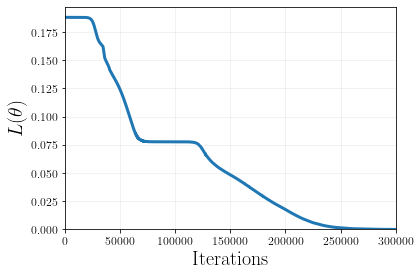

In [16]:
plt.figure()
plt.plot(losses, lw=3)
plt.ylim(ymin=0)
plt.xlim(xmin=0, xmax=300000)
plt.ylabel(r'$L(\theta)$',fontsize=20)
plt.xlabel('Iterations', fontsize=20)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('loss_profile.pdf',fontsize=20)
plt.show()